In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR100('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR100('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)
print(len(train_loader),len(valid_loader))


Files already downloaded and verified
Files already downloaded and verified
1250 313


In [3]:
train_loader.dataset.targets[0]


19

In [13]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
    self.dropout=nn.Dropout(0.8)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(512 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 100)  # Output size should match the number of classes in CIFAR-100

  def forward(self, x):
      x = self.pool(nn.functional.relu(self.conv1(x)))
      x = self.pool(nn.functional.relu(self.conv2(x)))
      x = self.pool(nn.functional.relu(self.conv3(x)))
      x = (nn.functional.relu(self.conv4(x)))
      x = x.view(-1, 512 * 4 * 4)
      x = nn.functional.relu(self.fc1(self.dropout(x)))
      x = nn.functional.relu(self.fc2(self.dropout(x)))
      x = self.fc3(self.dropout(x))
      return x
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
  model.cuda()
import torch.optim as optim
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adamax(model.parameters(), lr=.001)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.8, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=100, bias=True)
)


In [14]:
# number of epochs to train the model
n_epochs = 50#[*range(30)]
#List to store loss to visualize
train_losslist = []
val_losslist = []
valid_loss_min = np.Inf # track change in validation loss
patience = 25
epochs_without_improvement = 0
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # print(data.shape)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # print(output.shape,target)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # print(output,target)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/(len(train_loader)*32)
    valid_loss = valid_loss/(len(valid_loader)*32)
    train_losslist.append(train_loss)
    val_losslist.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    # Check if it's time to stop training
#     if epochs_without_improvement >= patience:
#         print(f'Early stopping after {patience} epochs without improvement.')
#         break


Epoch: 1 	Training Loss: 4.558849 	Validation Loss: 4.395928
Validation loss decreased (inf --> 4.395928).  Saving model ...
Epoch: 2 	Training Loss: 4.367491 	Validation Loss: 4.191279
Validation loss decreased (4.395928 --> 4.191279).  Saving model ...
Epoch: 3 	Training Loss: 4.202892 	Validation Loss: 4.008659
Validation loss decreased (4.191279 --> 4.008659).  Saving model ...
Epoch: 4 	Training Loss: 4.056596 	Validation Loss: 3.832982
Validation loss decreased (4.008659 --> 3.832982).  Saving model ...
Epoch: 5 	Training Loss: 3.917681 	Validation Loss: 3.682826
Validation loss decreased (3.832982 --> 3.682826).  Saving model ...
Epoch: 6 	Training Loss: 3.775932 	Validation Loss: 3.552320
Validation loss decreased (3.682826 --> 3.552320).  Saving model ...
Epoch: 7 	Training Loss: 3.636164 	Validation Loss: 3.400905
Validation loss decreased (3.552320 --> 3.400905).  Saving model ...
Epoch: 8 	Training Loss: 3.510627 	Validation Loss: 3.294797
Validation loss decreased (3.40090

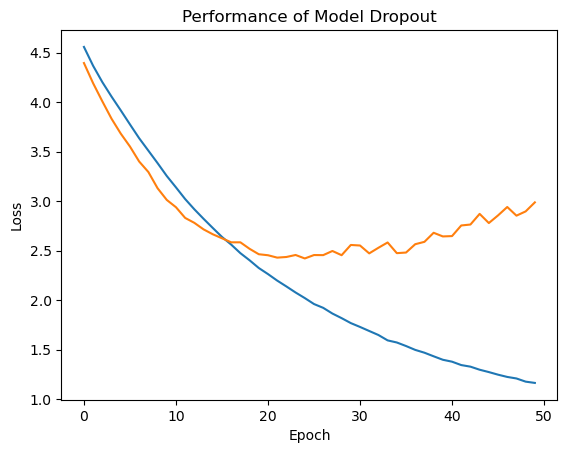

In [15]:
from matplotlib import pyplot as plt
plt.plot(range(50), train_losslist)
plt.plot(range(50), val_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model Dropout")
plt.show()

In [17]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [18]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)


    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        # print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print(len(test_loader.dataset),len(test_loader)*32)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(100):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

10000 10016
Test Loss: 2.435573

Test Accuracy of     0: 71% (71/100)
Test Accuracy of     1: 48% (48/100)
Test Accuracy of     2: 32% (32/100)
Test Accuracy of     3: 26% (26/100)
Test Accuracy of     4: 13% (13/100)
Test Accuracy of     5: 29% (29/100)
Test Accuracy of     6: 42% (42/100)
Test Accuracy of     7: 28% (28/100)
Test Accuracy of     8: 48% (48/100)
Test Accuracy of     9: 51% (51/100)
Test Accuracy of    10: 15% (15/100)
Test Accuracy of    11: 10% (10/100)
Test Accuracy of    12: 43% (43/100)
Test Accuracy of    13: 21% (21/100)
Test Accuracy of    14: 26% (26/100)
Test Accuracy of    15: 15% (15/100)
Test Accuracy of    16: 42% (42/100)
Test Accuracy of    17: 67% (67/100)
Test Accuracy of    18: 31% (31/100)
Test Accuracy of    19: 16% (16/100)
Test Accuracy of    20: 75% (75/100)
Test Accuracy of    21: 68% (68/100)
Test Accuracy of    22: 26% (26/100)
Test Accuracy of    23: 75% (75/100)
Test Accuracy of    24: 63% (63/100)
Test Accuracy of    25: 15% (15/100)
Test 

# **With Lrp Dropout**

In [15]:
import copy
import torch.nn as nn
import torch.nn.functional as F

def newlayer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    if isinstance(layer, torch.nn.MaxPool2d):
      return layer
    else:
      layer.weight = torch.nn.Parameter(g(layer.weight))
      layer.bias = torch.nn.Parameter(g(layer.bias))
      return layer

In [17]:
class LRPDropout(nn.Module):
    def __init__(self,dropoutrate=0.1):
        super(LRPDropout, self).__init__()
        self.mask = None
        self.rate=dropoutrate

    def forward(self, x):
        if self.training:
            if self.mask is None:
              return x
            # During training, apply dropout
            # print(self.mask.shape,x.shape)
            output = x * self.mask / (1 - self.rate)
        else:
            # During evaluation, don't apply dropout
            output = x
        return output



    def update_mask(self, lrp_values, percentile=50):
        percentile=self.rate*100
        
        # calculate the threshold based on LRP values
        threshold = np.percentile((torch.abs(lrp_values).cpu().numpy()), percentile)

        # create a binary mask based on the threshold
        self.mask = (torch.abs(lrp_values) < threshold).float().to("cuda")
        # print(self.mask)

In [18]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class NetLrp(nn.Module):
  def __init__(self):
    super(NetLrp, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3,padding=1)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(64,128, 3,padding=1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(128,256, 3,padding=1)
    self.pool3 = nn.MaxPool2d(2, 2)
    self.conv4 = nn.Conv2d(256,512,3,padding=1)
    self.dropout1=LRPDropout(0.5)
    self.fc1 = nn.Linear(512 * 4 * 4, 1024)
    self.dropout2=LRPDropout(0.5)
    self.fc2 = nn.Linear(1024, 512)
    self.dropout3=LRPDropout(0.5)
    self.fc3 = nn.Linear(512, 100)




  def forward(self, x):
      x = self.pool1(nn.functional.relu(self.conv1(x)))
      x = self.pool2(nn.functional.relu(self.conv2(x)))
      x = self.pool3(nn.functional.relu(self.conv3(x)))
      x = (nn.functional.relu(self.conv4(x)))
      x = self.dropout1(x)
      x = x.view(-1, 512 * 4 * 4)
      x = nn.functional.relu(self.fc1(x))
      x = nn.functional.relu(self.fc2(self.dropout2(x)))
      x = self.fc3(self.dropout3(x))
      return x
# create a complete CNN
modellrp = NetLrp()
print(modellrp)
# move tensors to GPU if CUDA is available
if train_on_gpu:
  modellrp.cuda()

NetLrp(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): LRPDropout()
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (dropout2): LRPDropout()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout3): LRPDropout()
  (fc3): Linear(in_features=512, out_features=100, bias=True)
)


In [19]:



def LRP_individual(model, X, target, device):
    # Get the list of layers of the network
    layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)][1:]
    # print(layers)
    # Propagate the input
    L = len(layers)
    A = [X] + [X] * L # Create a list to store the activation produced by each layer
    # print(layers)
    # print(len(A),layers)
    for layer in range(L):
        # print(A[layer].shape,layers[layer])
        # print(layers[layer])
        if isinstance(layers[layer],torch.nn.Linear):
          # print(layers[layer])
          A[layer]=A[layer].reshape(-1,1,layers[layer].in_features)
        if isinstance(layers[layer], LRPDropout):
          # print(A[layer].shape)
          A[layer + 1] =A[layer]
        else:

          A[layer + 1] = layers[layer].forward(A[layer])
    # Get the relevance of the last layer using the highest classification score of the top layer
    T = A[-1].to(device)  # Remove .numpy().tolist()
    index = target
    # print(T.shape)
    T = torch.abs(T) * 0
    # print(T)
    T[-1,0, index] = 1  # Modify to index the element directly
    T = T.to(device)
    # Create the list of relevances with (L + 1) elements and assign the value of the last one
    R = [None] * L + [(A[-1] * T).data + 1e-6]
    # print("hi")
     # Propagation procedure from the top-layer towards the lower layers
    for layer in range(0, L)[::-1]:

        if isinstance(layers[layer], torch.nn.Conv2d) or isinstance(layers[layer], torch.nn.Conv3d) \
                or isinstance(layers[layer],torch.nn.Linear) or isinstance(layers[layer],torch.nn.MaxPool2d) :


            rho = lambda p: p

            A[layer] = A[layer].data.requires_grad_(True).to(device)

            # Step 1: Transform the weights of the layer and executes a forward pass
            z = newlayer(layers[layer], rho)

            z=z.forward(A[layer]) + 1e-9
            # print(layers[layer],z.shape,A[layer].shape)
            # print(z.shape,R[layer+1].shape,layers[layer],A[layer].shape)
            # Step 2: Element-wise division between the relevance of the next layer and the denominator
            s = (R[layer+1] / z).data
            # print(s)
            # Step 3: Calculate the gradient and multiply it by the activation layer
            (z * s).sum().backward()
            c = A[layer].grad
            R[layer] = (A[layer] * c).cuda().data
            # R[layer] = R[layer + 1]
            # print(R)
            if layer == 8:
                # print("hi")
                R[layer] = R[layer].reshape(-1,512,4,4)
        else:
            # print(layers[layer],"else")
            R[layer] = R[layer + 1]
    # Return the relevance of the all the layers
    return R

import numpy as np
# model.eval()
# print(train_loader.dataset.data[0:12].shape)
Rel = LRP_individual(modellrp, torch.from_numpy(train_loader.dataset.data[0:5]).permute(0,3, 1, 2).float().to("cuda"),[1,2,3,4],device="cuda")
[print(tensor.shape,end="...") for tensor in Rel]


torch.Size([5, 3, 32, 32])...torch.Size([5, 64, 32, 32])...torch.Size([5, 64, 16, 16])...torch.Size([5, 128, 16, 16])...torch.Size([5, 128, 8, 8])...torch.Size([5, 256, 8, 8])...torch.Size([5, 256, 4, 4])...torch.Size([5, 512, 4, 4])...torch.Size([5, 512, 4, 4])...torch.Size([5, 1, 1024])...torch.Size([5, 1, 1024])...torch.Size([5, 1, 512])...torch.Size([5, 1, 512])...torch.Size([5, 1, 100])...

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [20]:
import torch.optim as optim
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adamax(modellrp.parameters(), lr=.001)

In [21]:
# number of epochs to train the model
n_epochs = 50#[*range(30)]
#List to store loss to visualize
train_losslist = []
valid_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    modellrp.train()
    for data, target in train_loader:
        # print(data.shape)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modellrp(data)
        # print(output)
        # calculate the batch loss
#         print(output.shape,target.shape)
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        Rel = LRP_individual(modellrp, data.reshape(-1,3,32,32).float().to("cuda"),target,device="cuda")
        # [print(tensor.shape,end="...") for tensor in Rel]
        # for i in range(len(data)):
        #       # print(target[i].item())
        #       # print(d.reshape(3,32,32).shape)
        #       Rel = LRP_individual(modellrp, data.reshape(3,32,32).float().to("cuda"),target[i].item(),device="cuda")
        #       if len(avg_tensor)<=0:
        #         # print("hi")
        #         avg_tensor=Rel
        #       # print(len(avg_tensor),len(Rel))
        #       for i in range(len(Rel)):
        #         avg_tensor[i]+=Rel[i]
        avg_tensor=torch.tensor([])
        for i in range(len(Rel)):
            if(len(avg_tensor)==0):
                avg_tensor=Rel
                for j in range(len(Rel)):
                    avg_tensor[j] = torch.mean(Rel[j], dim=0)
                
#           print(avg_tensor[i].shape)
            avg_tensor[i] = torch.mean(Rel[i], dim=0)
#           print(avg_tensor[i].shape)
        # [print(tensor.shape,end="...") for tensor in avg_tensor]
        modellrp.dropout1.update_mask(avg_tensor[8])
        modellrp.dropout2.update_mask(avg_tensor[10])
        # # print("Hi")
        modellrp.dropout3.update_mask(avg_tensor[12])
        # After each epoch, calculate the LRP and update the dropout masks
        # print("hi")



    ######################
    # validate the model #
    ######################
    modellrp.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modellrp(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/(len(train_loader)*32)
    valid_loss = valid_loss/(len(valid_loader)*32)
    # print(len(train_loader),len(valid_loader))
    train_losslist.append(train_loss)
    valid_losslist.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(modellrp.state_dict(), 'model_cifar_lrp_0.5_abs_highdrop.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 4.367310 	Validation Loss: 3.970219
Validation loss decreased (inf --> 3.970219).  Saving model ...
Epoch: 2 	Training Loss: 4.001310 	Validation Loss: 3.641575
Validation loss decreased (3.970219 --> 3.641575).  Saving model ...
Epoch: 3 	Training Loss: 3.721627 	Validation Loss: 3.406245
Validation loss decreased (3.641575 --> 3.406245).  Saving model ...
Epoch: 4 	Training Loss: 3.463113 	Validation Loss: 3.226470
Validation loss decreased (3.406245 --> 3.226470).  Saving model ...
Epoch: 5 	Training Loss: 3.216634 	Validation Loss: 2.968799
Validation loss decreased (3.226470 --> 2.968799).  Saving model ...
Epoch: 6 	Training Loss: 3.014936 	Validation Loss: 2.782899
Validation loss decreased (2.968799 --> 2.782899).  Saving model ...
Epoch: 7 	Training Loss: 2.809987 	Validation Loss: 2.657320
Validation loss decreased (2.782899 --> 2.657320).  Saving model ...
Epoch: 8 	Training Loss: 2.628433 	Validation Loss: 2.525708
Validation loss decreased (2.65732

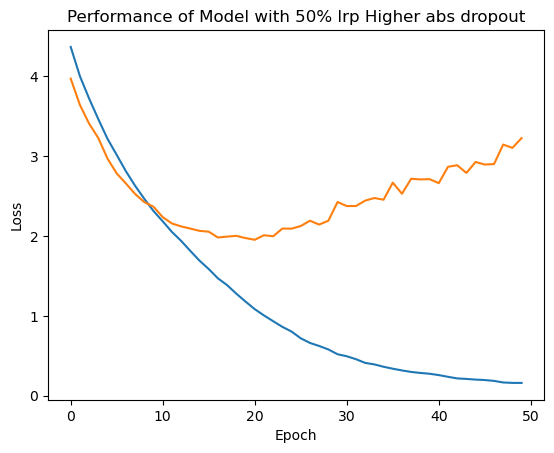

In [22]:
from matplotlib import pyplot as plt
plt.plot(range(50), train_losslist)
plt.plot(range(50), valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model with 50% lrp Higher abs dropout")
plt.show()

In [24]:
modellrp.load_state_dict(torch.load('model_cifar_lrp_0.5_abs_highdrop.pt'))

<All keys matched successfully>

In [25]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

modellrp.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = modellrp(data)


    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(100):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.910443

Test Accuracy of     0: 75% (75/100)
Test Accuracy of     1: 66% (66/100)
Test Accuracy of     2: 44% (44/100)
Test Accuracy of     3: 21% (21/100)
Test Accuracy of     4: 18% (18/100)
Test Accuracy of     5: 44% (44/100)
Test Accuracy of     6: 61% (61/100)
Test Accuracy of     7: 53% (53/100)
Test Accuracy of     8: 52% (52/100)
Test Accuracy of     9: 65% (65/100)
Test Accuracy of    10: 28% (28/100)
Test Accuracy of    11: 20% (20/100)
Test Accuracy of    12: 44% (44/100)
Test Accuracy of    13: 49% (49/100)
Test Accuracy of    14: 35% (35/100)
Test Accuracy of    15: 37% (37/100)
Test Accuracy of    16: 50% (50/100)
Test Accuracy of    17: 76% (76/100)
Test Accuracy of    18: 57% (57/100)
Test Accuracy of    19: 40% (40/100)
Test Accuracy of    20: 72% (72/100)
Test Accuracy of    21: 78% (78/100)
Test Accuracy of    22: 40% (40/100)
Test Accuracy of    23: 77% (77/100)
Test Accuracy of    24: 70% (70/100)
Test Accuracy of    25: 39% (39/100)
Test Accuracy of 

In [36]:
class LRP_Random_Dropout(nn.Module):
    def __init__(self):
        super(LRP_Random_Dropout, self).__init__()
        self.mask = None

    def forward(self, x):
        if self.mask is None:
            return x
        self.mask = (torch.rand(x.shape) > 0.1).float().to("cpu")
        # print(self.mask.shape,x.shape)
        return x * self.mask / (1 - 0.1)

    # def update_mask(self, lrp_values, percentile=10):
    #     # calculate the threshold based on LRP values
    #     # threshold = np.percentile((lrp_values), percentile)

    #     # create a binary mask based on the threshold

    #     print(self.mask)